# Truncation and censoring

Let us start by defining left-truncation and left-censoring:

Our data are left-truncated when observations below a threshold $k$ are not present in the dataset. For example, if we want to study the size of certain fish based on the specimens captured with a net, fish smaller than the net grid won't be present in our sample.

Our data are left-censored at same level $k$ if every observation with a value below $k$ is present in the dataset, but the actual value is unknown. This happens, for example, when we have a sensor (measuring instrument) that cannot detect values below a certain level. 

In [10]:
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt

!pip install arviz

np.random.seed(42)
D=stats.norm(0.75,1.5).rvs(20) #we generate data from Normal(0.75,1.5)
print(D)
trunc=D[D>0.5]
print("example of left truncation at 0.5=\n",trunc)
cens=np.clip(D,0.5,np.inf)
print("example of left censoring at 0.5=\n",cens)

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 727kB 11.0MB/s 
     |████████████████████████████████| 4.3MB 24.6MB/s 
     |████████████████████████████████| 296kB 37.2MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
[ 1.49507123  0.54260355  1.72153281  3.03454478  0.39876994  0.39879456
  3.11881922  1.90115209  0.04578842  1.56384007  0.05487346  0.05140537
  1.11294341 -2.11992037 -1.83737675 -0.09343129 -0.76924668  1.221371
 -0.61203611 -1.36845555]
example of left truncation at 0.5=
 [1.49507123 0.54260355 1.72153281 3.03454478 3.11881922 1.90115209
 1.56384007 1.11294341 1.221371  ]
example of left censoring at 0.5=
 [1.49507123 0.54260355 1.72153281 3.03454478 0.5        0.5
 3.11881922 1.90115209 0.5        1.56384007 0.5        0.5
 1.11294341 0.5        0.5        0.5        0.5        1.221371
 0.5        0.5       ]


In this notebook, we will focus  on left-truncation and left-censoring, but the concepts we will discuss generalize to all types of censoring and truncation (right, left, and interval).

Question: given either truncated or censored data (we assume we know the level $k$), how can we estimate back the parameters of the Normal distribution we used to generate the data?

Let's start with truncation.

If we ignore the truncation and treat the incomplete data as complete, the sample average is inconsistent for the population mean, because all observations below the truncation point are missing. In our example, the true mean is outside the 95% confidence interval for
the estimated mean.

True parameters= 0.75 1.5
Sample mean and std= 1.7867791034126501 0.9436743900005388


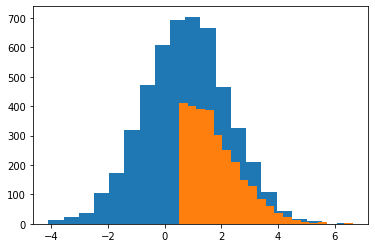

In [2]:
D=stats.norm(0.75,1.5).rvs(5000) #we generate MORE data from Normal(0.75,1.5)
trunc=D[D>0.5]

plt.hist(D,bins=20);
plt.hist(trunc,bins=20);
print("True parameters=",0.75,1.5)
print("Sample mean and std=",np.mean(trunc),np.sqrt(np.mean((trunc-np.mean(trunc))**2)))

How can we fix the MLE estimate above to account for the truncation? Actually, we will define a PyMC3 models that allows us to estimate mean and variance of the Normal distribution that generated the data under a known truncation.

In [3]:
import theano.tensor as tt

with pm.Model() as mymodel:
    mu = pm.Normal('mu',0.0,30)
    sigma = pm.Uniform('sigma',0.0001,30)
    x = pm.TruncatedNormal('x',mu,sigma,lower=0.5, observed=trunc)
with mymodel:
    est=pm.find_MAP()
print("True parameters=",0.75,1.5)
print("MAP estimates=",est['mu'],est['sigma'])

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3,414.1, ||grad|| = 0.00029296: 100%|██████████| 23/23 [00:00<00:00, 1069.84it/s]  


True parameters= 0.75 1.5
MAP estimates= 0.7696771679693437 1.4830059636830137


The above model is very similar to the one we saw in Section 4.2 of `Notes.pdf`. The main difference is that we tell the model that the distribution is truncated below $0.5$ using `pm.TruncatedNormal`. Note that `pm.TruncatedNormal` accepts two inputs `lower` and `upper` and so it allows us to deal with left, right an interval truncation.

You can see that the estimates are much better then the sample mean and standard deviation.

A better way than MAP is to compute the posterior of $\mu,\sigma$ that also gives us information on the uncertainty 

In [4]:
with mymodel:
    samples=pm.sample(5000,tune=5000, chains=1) #, step=pm.Metropolis())
#print(estimate['mu'],estimate['sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 10000/10000 [00:18<00:00, 539.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Posterior means= 0.7519968661392742 1.4912152652308814


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  # Remove the CWD from sys.path while we load stuff.


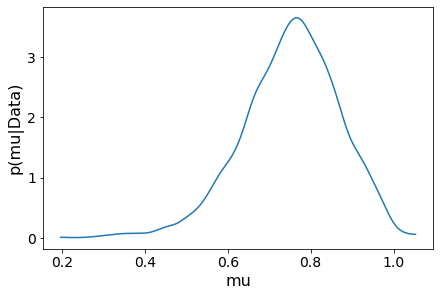

<Figure size 432x288 with 0 Axes>

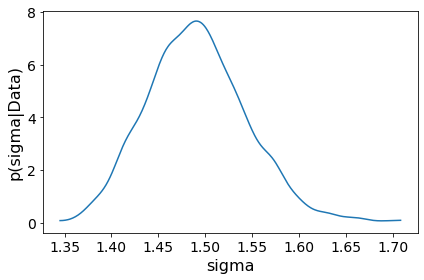

In [11]:
import arviz as az
print("Posterior means=",np.mean(samples['mu']),np.mean(samples['sigma']))
az.plot_dist(samples['mu'])#this is the posterior PDF
plt.xlabel("mu",fontsize=16)
plt.ylabel("p(mu|Data)",fontsize=16)
plt.figure()
az.plot_dist(samples['sigma'])#this is the posterior PDF
plt.xlabel("sigma",fontsize=16)
plt.ylabel("p(sigma|Data)",fontsize=16)
plt.tight_layout()

The posterior quantifies the uncertainty on the estimates of mean and standard deviation.

## Censoring
Now we consider an example with censored data rather than truncated data to demonstrate the difference between the two.

True parameters= 0.75 1.5
Sample mean and std= 1.2348158144902235 0.9557986939461909


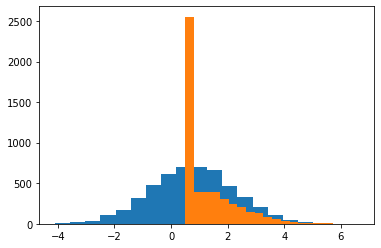

In [12]:
np.random.seed(42)
D=stats.norm(0.75,1.5).rvs(5000) #we generate daata from Normal(0.75,1.5)
cens=np.clip(D,0.5,np.inf)

plt.hist(D,bins=20);
plt.hist(cens,bins=20);
print("True parameters=",0.75,1.5)
print("Sample mean and std=",np.mean(cens),np.sqrt(np.mean((cens-np.mean(cens))**2)))

There is a spike on the left of the histogram because values below $0.5$ are recorded as being equal to the $0.5$.
Computing the sample mean and standard deviation for the dataset will not provide appropriate estimates for the underlying uncensored Gaussian distribution.

We need to model censoring.
Consider the observations

In [13]:
cens[0:9]

array([1.49507123, 0.54260355, 1.72153281, 3.03454478, 0.5       ,
       0.5       , 3.11881922, 1.90115209, 0.5       ])

when a value equal to $0.5$ means that the censored observation belonged to the interval $[-\infty,0.5]$.

Therefore, the generative model for a left-censored observation $y$ is

$$
y= \left\{\begin{array}{ll}
0.5 & \text{if } y_{nc}\in (-\infty,0.5]\\
y_{nc} & \text{if } y_{nc}\in [0.5,\infty)
\end{array}\right.
$$

where $y_{nc}$ is the observation before censoring and so  $p(y_{nc})= N(y_{nc},\mu,\sigma)$ is Normal distributed because this is the distribution we have assumed before censoring.

Therefore the likelihood model is

$$
p(y=0.5)= \int_{-\infty}^{0.5} N(y_{nc},\mu,\sigma) d y_{nc}=\Phi(0.5,\mu,\sigma)
$$

where $\Phi(0.5,\mu,\sigma)$ is the CDF of a normal distribution with mean $\mu$ and standard deviation $\sigma$ computed at $0.5$.

and for $y>0.5$, 

$$
p(y) = N(y,\mu,\sigma)
$$

This is a well-defined probability because

$$
p(y=0.5) +  \int_{0.5}^{\infty} N(y_{nc},\mu,\sigma)  d y_{nc} =1
$$

Hence for instance for the dataset 
$$
[3.03, 0.5       , 0.5       , 3.11]
$$

assuming independence, the likelihood is

$$
p(Data|\mu,\sigma)=\Phi(0.5,\mu,\sigma)^2 N(3.03,\mu,\sigma)N(3.11,\mu,\sigma)
$$

How can we implement this in PymC3?

We exploit the fact that we can write the CDF of a normal distribution using the `erfc` function that is implemented in theano:
https://en.wikipedia.org/wiki/Error_function#Cumulative_distribution_function

In order to write the power $\Phi(0.5,\mu,\sigma)^{m}$ where $m$ is the number of censored observation, we use the Bernoulli likelihood.  




In [14]:
import theano.tensor as tt

def custom_dist_logp(mu,sigma,Data):
    return pm.Bernoulli.dist(0.5*tt.erfc(-(Data-mu)/sigma/np.sqrt(2))).logp(1.0)

D_noncensored=cens[cens>0.5]
D_censored=cens[cens==0.5]
mymodel=pm.Model()
with mymodel:
    mu = pm.Normal('mu',0.0,30)
    sigma = pm.Uniform('sigma',0.0001,30)
    l1=pm.Normal('Like_noncensored',mu,sigma,observed=D_noncensored)
    l2=pm.DensityDist('Like_censored',custom_dist_logp,observed=dict(mu=mu, sigma=sigma, Data=D_censored))

with mymodel:
    est=pm.find_MAP()
print("True parameters=",0.75,1.5)
print("MAP estimates=",est['mu'],est['sigma'])

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -6,946.2, ||grad|| = 661.78: 100%|██████████| 18/18 [00:00<00:00, 1053.76it/s] 

True parameters= 0.75 1.5
MAP estimates= 0.7660690157894767 1.4842989050447202


You can see that the estimates are much better then the sample mean and standard deviation.

A better way than MAP is to compute the posterior of $\mu,\sigma$ that also gives us information on the uncertainty 

In [15]:
with mymodel:
    samples=pm.sample(5000,tune=5000, chains=1)
#print(estimate['mu'],estimate['sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 10000/10000 [00:16<00:00, 613.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Posterior means= 0.7658156340699124 1.4849763098632867


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  # Remove the CWD from sys.path while we load stuff.


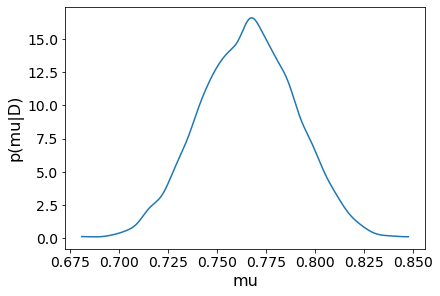

<Figure size 432x288 with 0 Axes>

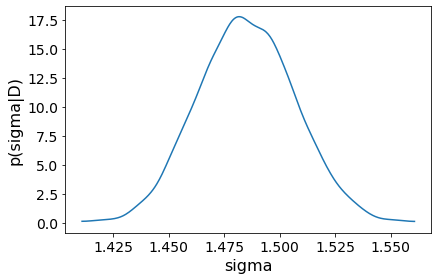

In [16]:
import arviz as az
print("Posterior means=",np.mean(samples['mu']),np.mean(samples['sigma']))
az.plot_dist(samples['mu'])#this is the posterior PDF
plt.xlabel("mu",fontsize=16)
plt.ylabel("p(mu|D)",fontsize=16)
plt.figure()
az.plot_dist(samples['sigma'])#this is the posterior PDF
plt.xlabel("sigma",fontsize=16)
plt.ylabel("p(sigma|D)",fontsize=16)
plt.tight_layout()

You can notice how the posterior means are very close to the true value of the parameters.

In [21]:
import pymc3 as pm
import theano.tensor as tt
import arviz as az
def event_A(x,interval):
  return pm.math.log(pm.math.sigmoid((x-interval[0])*5000.0)*pm.math.sigmoid(-x+interval[1])*5000.0))

interval=[0.25,np.inf]# event A, w>0.25

mymodel=pm.Model()
with mymodel:
  x = pm.Normal(’x’,0.25,0.05) pm.DensityDist(’event’,event_A ,observed=dict(x=x,interval=interval))

with mymodel:
  samples=pm.sample(30000 ,tune=10000 , chains=1)

SyntaxError: ignored